In [97]:
import pandas as pd
import tensorflow as tf

from window import WindowGenerator
from utils import train_test_val_split

In [98]:
def train_case(case_df, model, in_width, out_steps, max_epochs):
    """ Train model for given case df. """
    
    outlets = [ col for col in case_df.columns.values if col.startswith('outlet') ]
    column_indices = { name: i for i, name in enumerate(case_df.columns) }

    train_df, test_df, val_df = train_test_val_split(case_df)
    # train_df, test_df, val_df = normalize_datasets(train_df, test_df, val_df)

    label_columns = outlets

    multi_window = WindowGenerator(
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        input_width=in_width,
        label_width=out_steps,
        shift=out_steps,
        label_columns=label_columns
    )

    history = model.fit(
        multi_window.train,
        epochs=max_epochs,
        validation_data=multi_window.val,
        verbose=0
        # callbacks=[early_stopping]
    )

    return multi_window, history

# Dataset

In [99]:
case_1 = pd.read_csv("datasets/case_1.csv")
case_2 = pd.read_csv("datasets/case_2.csv")
case_3 = pd.read_csv("datasets/case_3.csv")
case_4 = pd.read_csv("datasets/case_4.csv")
case_5 = pd.read_csv("datasets/case_5.csv")

In [100]:
outlets = [ col for col in case_1.columns.values if col.startswith('outlet') ]
label_columns = outlets
num_features = case_1.shape[1]

In [101]:
column_indices = { name: i for i, name in enumerate(case_1.columns) }

# Model Creation

In [102]:
IN_WIDTH = 8
OUT_STEPS = 8
MAX_EPOCHS = 20
features_size = len(label_columns)

In [103]:
print(f"Using {IN_WIDTH*5}s of data to predict {OUT_STEPS*5}s.")
print(f"Using {IN_WIDTH*5/60}min of data to predict {OUT_STEPS*5/60}min.")

Using 40s of data to predict 40s into de future.
Using 0.6666666666666666min of data to predict 0.6666666666666666min into de future.


In [104]:
CONV_WIDTH = 3 # default 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*features_size,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, features_size])
])

multi_conv_model.compile(loss=tf.losses.MeanSquaredError(),
                         optimizer=tf.optimizers.Adam(),
                         metrics=[tf.metrics.RootMeanSquaredError()])

# history = compile_and_fit(multi_conv_model, multi_window)

# IPython.display.clear_output()

# multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
# multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
# multi_window.plot(multi_conv_model)

## Case 1

In [105]:
window, history = train_case(
    case_df=case_1,
    model=multi_conv_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

2022-08-11 22:51:04.009813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-11 22:51:04.616343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [106]:
tf.keras.utils.plot_model(multi_conv_model, "multi_conv_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


label_col_index 135
label_col_index 135
label_col_index 135


2022-08-11 22:51:12.632151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


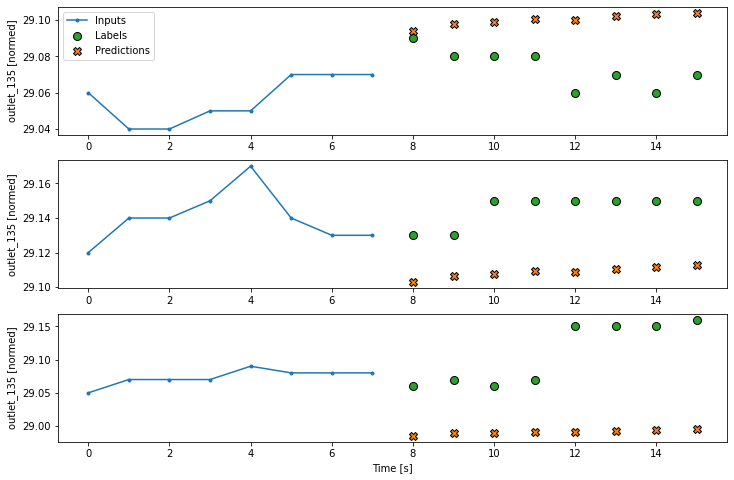

In [107]:
window.plot(multi_conv_model, plot_col="outlet_135")

In [108]:
losses = pd.DataFrame(history.history)

<AxesSubplot:title={'center':'Model loss'}, xlabel='Epoch', ylabel='Loss'>

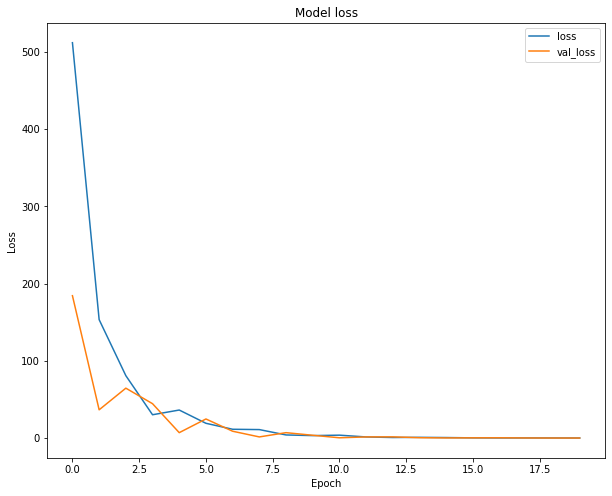

In [109]:
losses[['loss', 'val_loss']].plot(figsize=(10,8), xlabel="Epoch", ylabel="Loss", title="Model loss")

<AxesSubplot:title={'center':'RMSE'}, xlabel='Epoch', ylabel='RMSE'>

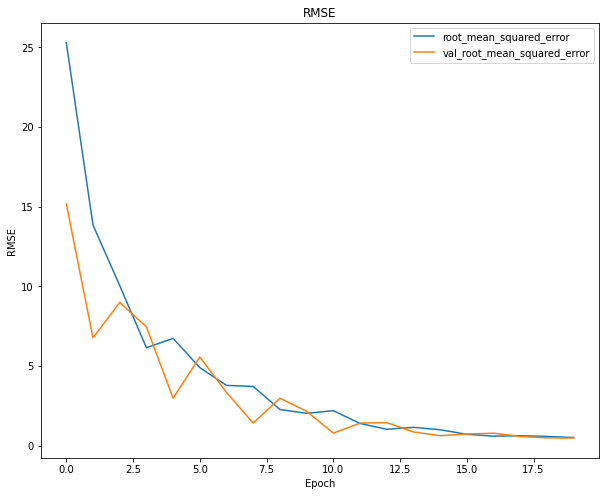

In [110]:
losses[['root_mean_squared_error', 'val_root_mean_squared_error']].plot(figsize=(10,8), xlabel="Epoch", ylabel="RMSE", title="RMSE")

In [111]:
multi_conv_model.evaluate(window.test)

1/1 [==============================] - 0s 253ms/step - loss: 0.1655 - root_mean_squared_error: 0.4557


[0.16550803184509277, 0.45568719506263733]

## Case 2

In [112]:
window, history = train_case(
    case_df=case_2,
    model=multi_conv_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

label_col_index 135
label_col_index 135
label_col_index 135


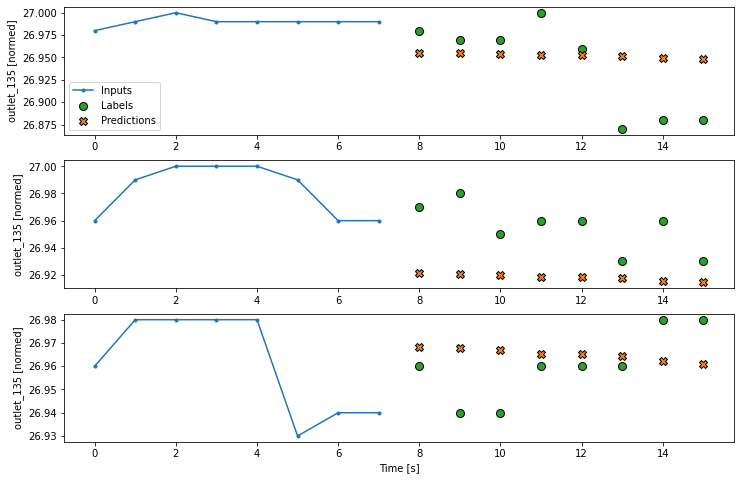

In [113]:
window.plot(multi_conv_model, plot_col="outlet_135")

In [114]:
losses = pd.DataFrame(history.history)

<AxesSubplot:title={'center':'Model loss'}, xlabel='Epoch', ylabel='Loss'>

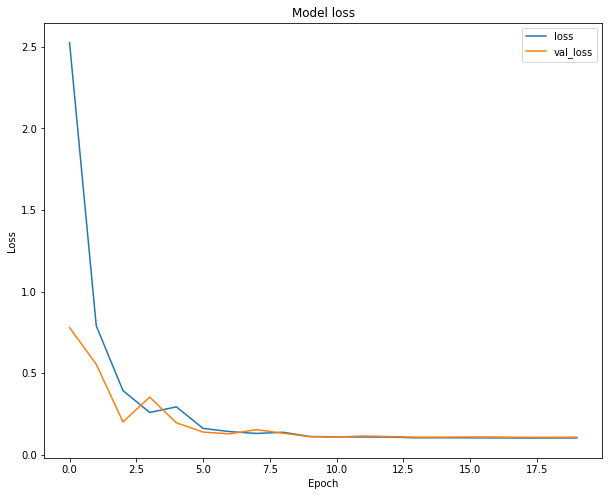

In [115]:
losses[['loss', 'val_loss']].plot(figsize=(10,8), xlabel="Epoch", ylabel="Loss", title="Model loss")

<AxesSubplot:title={'center':'RMSE'}, xlabel='Epoch', ylabel='RMSE'>

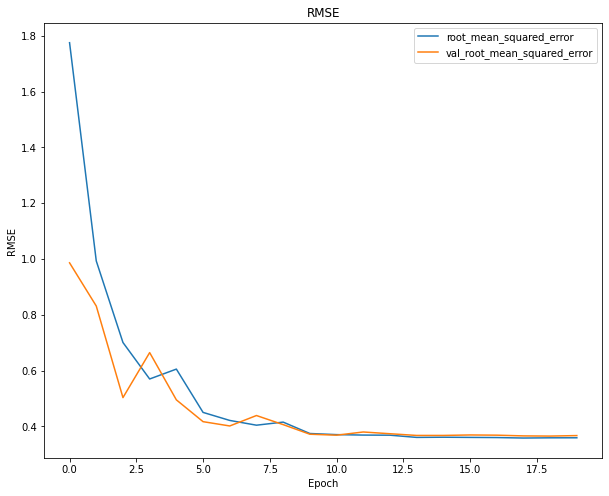

In [116]:
losses[['root_mean_squared_error', 'val_root_mean_squared_error']].plot(figsize=(10,8), xlabel="Epoch", ylabel="RMSE", title="RMSE")

In [117]:
multi_conv_model.evaluate(window.test)

1/1 [==============================] - 0s 266ms/step - loss: 0.1028 - root_mean_squared_error: 0.3540


[0.10277867317199707, 0.3540492653846741]

## Case 3

In [118]:
window, history = train_case(
    case_df=case_3,
    model=multi_conv_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

label_col_index 135
label_col_index 135
label_col_index 135


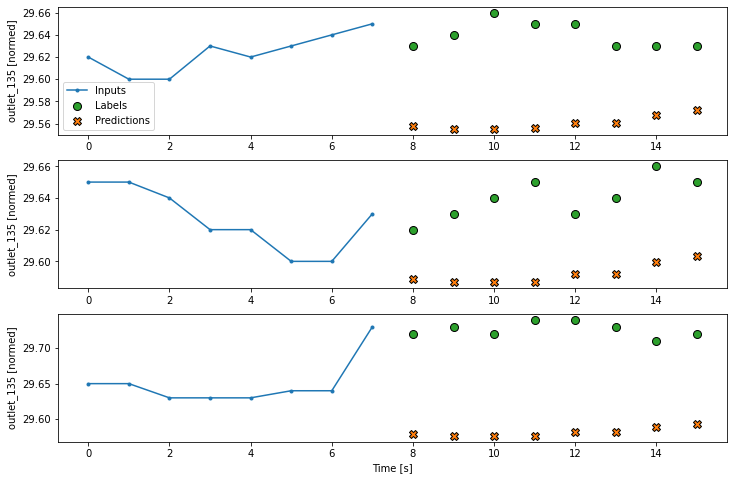

In [119]:
window.plot(multi_conv_model, plot_col="outlet_135")

In [120]:
losses = pd.DataFrame(history.history)

<AxesSubplot:title={'center':'Model loss'}, xlabel='Epoch', ylabel='Loss'>

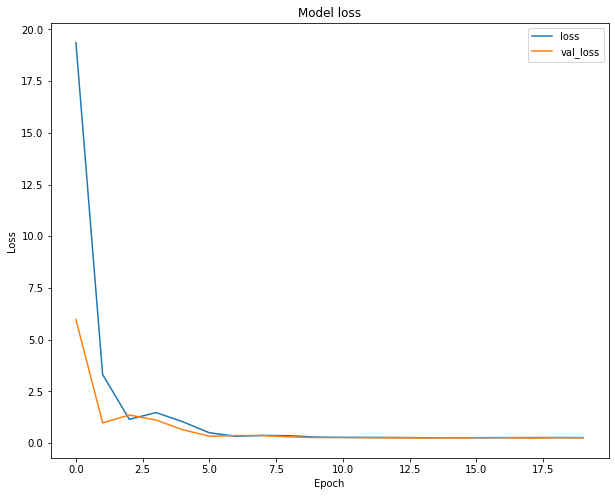

In [121]:
losses[['loss', 'val_loss']].plot(figsize=(10,8), xlabel="Epoch", ylabel="Loss", title="Model loss")

<AxesSubplot:title={'center':'RMSE'}, xlabel='Epoch', ylabel='RMSE'>

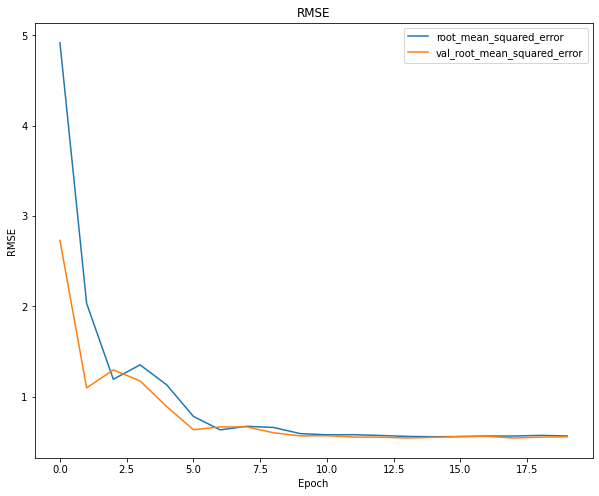

In [122]:
losses[['root_mean_squared_error', 'val_root_mean_squared_error']].plot(figsize=(10,8), xlabel="Epoch", ylabel="RMSE", title="RMSE")

In [123]:
multi_conv_model.evaluate(window.test)

1/1 [==============================] - 0s 260ms/step - loss: 0.2159 - root_mean_squared_error: 0.5254


[0.21585382521152496, 0.5254336595535278]

## Case 4

In [124]:
window, history = train_case(
    case_df=case_4,
    model=multi_conv_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

label_col_index 135
label_col_index 135
label_col_index 135


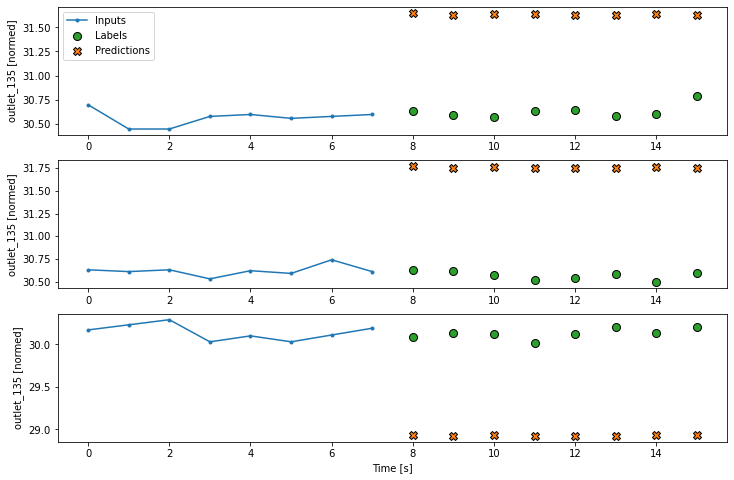

In [125]:
window.plot(multi_conv_model, plot_col="outlet_135")

In [126]:
losses = pd.DataFrame(history.history)

<AxesSubplot:title={'center':'Model loss'}, xlabel='Epoch', ylabel='Loss'>

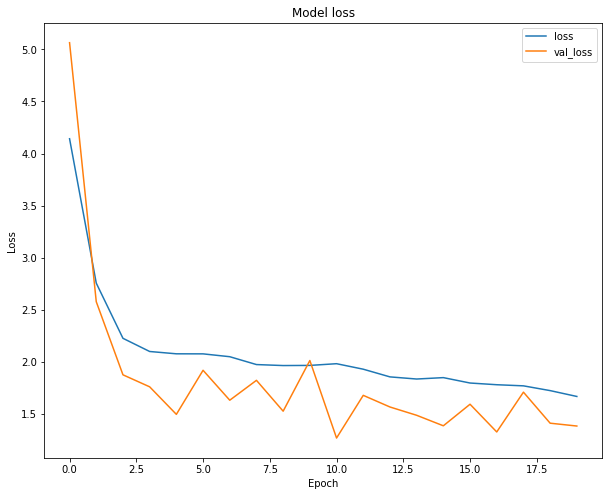

In [127]:
losses[['loss', 'val_loss']].plot(figsize=(10,8), xlabel="Epoch", ylabel="Loss", title="Model loss")

<AxesSubplot:title={'center':'RMSE'}, xlabel='Epoch', ylabel='RMSE'>

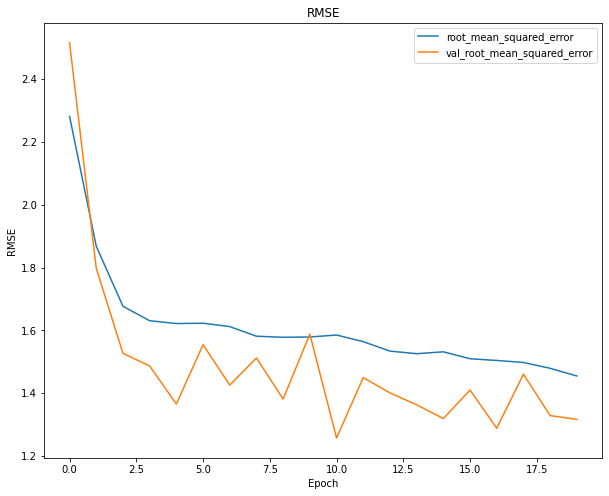

In [128]:
losses[['root_mean_squared_error', 'val_root_mean_squared_error']].plot(figsize=(10,8), xlabel="Epoch", ylabel="RMSE", title="RMSE")

In [129]:
multi_conv_model.evaluate(window.test)

1/1 [==============================] - 0s 260ms/step - loss: 1.4346 - root_mean_squared_error: 1.3362


[1.434556245803833, 1.3362466096878052]

## Case 5

In [130]:
window, history = train_case(
    case_df=case_5,
    model=multi_conv_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

label_col_index 135
label_col_index 135
label_col_index 135


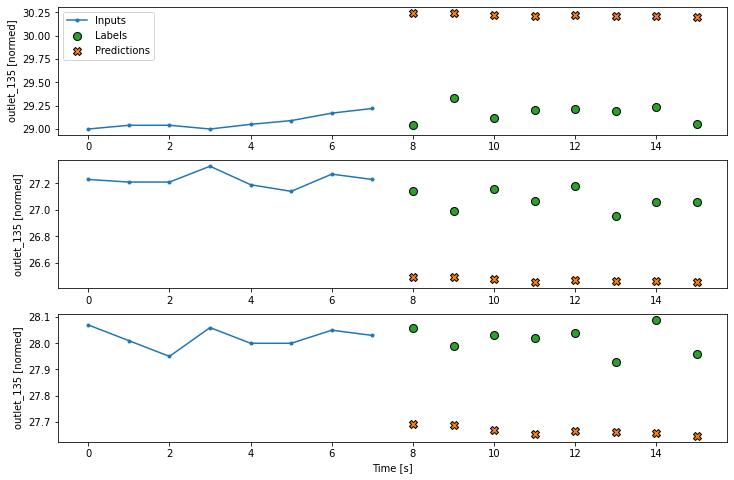

In [131]:
window.plot(multi_conv_model, plot_col="outlet_135")

In [132]:
losses = pd.DataFrame(history.history)

<AxesSubplot:title={'center':'Model loss'}, xlabel='Epoch', ylabel='Loss'>

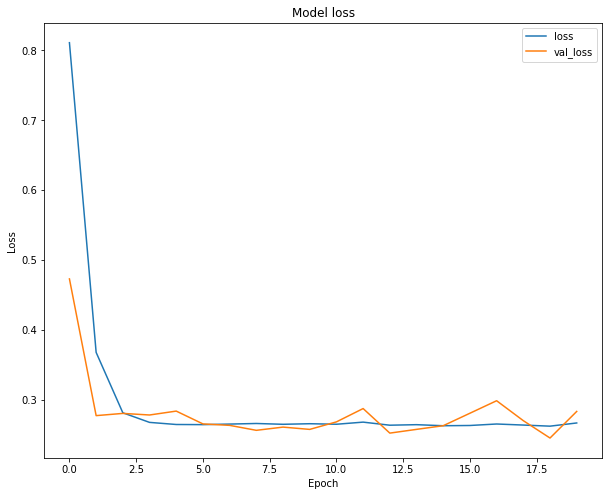

In [133]:
losses[['loss', 'val_loss']].plot(figsize=(10,8), xlabel="Epoch", ylabel="Loss", title="Model loss")

<AxesSubplot:title={'center':'RMSE'}, xlabel='Epoch', ylabel='RMSE'>

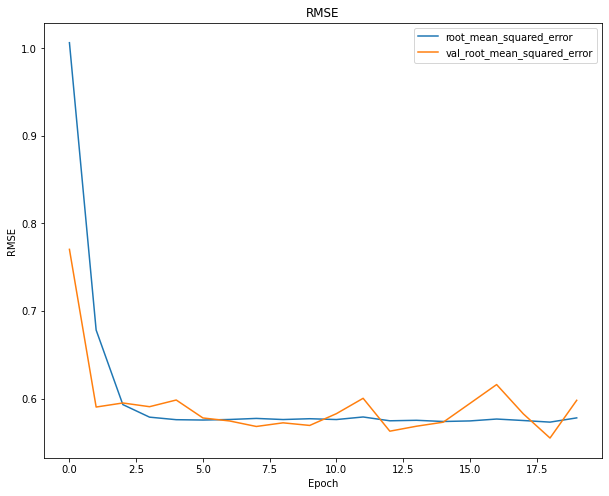

In [134]:
losses[['root_mean_squared_error', 'val_root_mean_squared_error']].plot(figsize=(10,8), xlabel="Epoch", ylabel="RMSE", title="RMSE")

In [139]:
result = multi_conv_model.evaluate(window.test)
print(result)

2/2 [==============================] - 0s 10ms/step - loss: 0.3763 - root_mean_squared_error: 0.6881
[0.37629228830337524, 0.6881282925605774]
